# Process the data
Experiment with Aarhus (2020):
- 18 keV
- pixel = 6.5/40 um


In [2]:
import numpy as np
from maximus48 import SSIM_131119 as SSIM
from maximus48 import var
import tifffile
import matplotlib.pyplot as plt
import os

## Read all paths

In [192]:
folder = '/mnt/beegfs/P14/2020/p3l-gleb1/20201129/RAW_DATA/imaging/'
#folder = '/Users/au704469/Documents/Postdoc/Results/X-ray_tomography/Brain_organoid_P14_DESY_Nov2020/Data_test/'+distance+'mm/'

In [4]:
#create the list all images in the folder
imlist = os.listdir(folder)

In [5]:
#[print(i) for i in imlist if ('0001.tiff') in i and not i.startswith('ff')]

## Open one projection for tests

In [146]:
# select just one distance and one acquisition/projection
def find_paths_single_distance_all(data_list, key, distance, image):
    return [i for i in data_list if (i.startswith(key) and distance in i and image in i)]

In [144]:
# this is also very ugly way of sorting
def find_counter(string, start='140mm_', end = '_00001.tiff'):
    return (string.split(start))[1].split(end)[0]

In [185]:
def find_ffs_simple(data_list, key):
    """
    Just for one image
    data_list: all data in the folder
    key: name of the file for which ff-s should be found
    """
    outs = [i for i in data_list if i.startswith('ff_'+key)]
    outs.sort()
    return outs

def find_ffs_list(data_list, image_list):
    """
    For a list of images
    data_list: all data in the folder
    image_list: list of images for which you want to find ff-s
    key: name of the file for which ff-s should be found
    """
    all_ff=[]
    for i in image_list:
        one_ff = []
        key = i[:-10]
        one_ff.append(find_ffs_simple(imlist, key))
        all_ff.append(one_ff)
        
    return all_ff

In [150]:
data_test = find_paths_single_distance_all(imlist, key ='try0', distance = '140mm', image = '0001.tiff')

# note - this sorting may not work for other examples (other than 140mm distance), needs to be tested
data_test = sorted(data_test, key=lambda i: int(find_counter(i)))

In [246]:
data_test

['try0_full_140mm_1_00001.tiff',
 'try0_full_140mm_2_00001.tiff',
 'try0_full_140mm_3_00001.tiff',
 'try0_full_140mm_4_00001.tiff',
 'try0_full_140mm_5_00001.tiff',
 'try0_full_140mm_6_00001.tiff',
 'try0_full_140mm_7_00001.tiff',
 'try0_full_140mm_8_00001.tiff',
 'try0_full_140mm_9_00001.tiff',
 'try0_full_140mm_10_00001.tiff',
 'try0_full_140mm_11_00001.tiff',
 'try0_full_140mm_12_00001.tiff',
 'try0_full_140mm_13_00001.tiff',
 'try0_full_140mm_14_00001.tiff',
 'try0_full_140mm_15_00001.tiff',
 'try0_full_140mm_16_00001.tiff',
 'try0_full_140mm_17_00001.tiff',
 'try0_full_140mm_18_00001.tiff',
 'try0_full_140mm_19_00001.tiff',
 'try0_full_140mm_20_00001.tiff',
 'try0_full_140mm_21_00001.tiff',
 'try0_full_140mm_22_00001.tiff',
 'try0_full_140mm_23_00001.tiff',
 'try0_full_140mm_24_00001.tiff',
 'try0_full_140mm_25_00001.tiff',
 'try0_full_140mm_26_00001.tiff',
 'try0_full_140mm_27_00001.tiff',
 'try0_full_140mm_28_00001.tiff',
 'try0_full_140mm_29_00001.tiff',
 'try0_full_140mm_30_00

In [187]:
ff_test = find_ffs_list(imlist, image_list = data_test)

In [188]:
ff_test

[[['ff_try0_full_140mm_1_00001.tiff',
   'ff_try0_full_140mm_1_00002.tiff',
   'ff_try0_full_140mm_1_00003.tiff',
   'ff_try0_full_140mm_1_00004.tiff',
   'ff_try0_full_140mm_1_00005.tiff',
   'ff_try0_full_140mm_1_00006.tiff',
   'ff_try0_full_140mm_1_00007.tiff',
   'ff_try0_full_140mm_1_00008.tiff',
   'ff_try0_full_140mm_1_00009.tiff',
   'ff_try0_full_140mm_1_00010.tiff',
   'ff_try0_full_140mm_1_00011.tiff',
   'ff_try0_full_140mm_1_00012.tiff',
   'ff_try0_full_140mm_1_00013.tiff',
   'ff_try0_full_140mm_1_00014.tiff',
   'ff_try0_full_140mm_1_00015.tiff',
   'ff_try0_full_140mm_1_00016.tiff',
   'ff_try0_full_140mm_1_00017.tiff',
   'ff_try0_full_140mm_1_00018.tiff',
   'ff_try0_full_140mm_1_00019.tiff',
   'ff_try0_full_140mm_1_00020.tiff',
   'ff_try0_full_140mm_1_00021.tiff',
   'ff_try0_full_140mm_1_00022.tiff',
   'ff_try0_full_140mm_1_00023.tiff',
   'ff_try0_full_140mm_1_00024.tiff',
   'ff_try0_full_140mm_1_00025.tiff',
   'ff_try0_full_140mm_1_00026.tiff',
   'ff_try0_

## Do ff-correction

In [95]:
#set the ROI of image first, the logic corresponds to FIJI (to be read (x,y,x1,y1 at the image - inverse to numpy!)
# ROI = (100,100,2048,2048) 


In [206]:
def ff_correct_one(image_path, ff_data, ROI=(0,0,2048,2048)):    
    """
    This function takes 1 data image and ff corrects it
    
    image_data: str
        path to images
    ff_data: list
        paths to ff
        
    Returns
    out: 3D numpy array
    """
    

    # read images
    images = tifffile.imread(folder+image_path)
    images = images[ROI[1]:ROI[3], ROI[0]:ROI[2]]

    #read ff-files
    flatfield = np.asarray([tifffile.imread(folder+im) for im in ff_data])
    flatfield = flatfield[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

    # please transpose the ff-array for the further ff-correction
    flatfield = np.transpose(flatfield, (1,2,0))
    
    # images should be set as special classes:
    image_class = SSIM.SSIM_const(images)
    ff_class = SSIM.SSIM_const(flatfield)

    # then, you can calculate SSIM metrics for each pair (data-image) - (ff-image)
    index = SSIM.SSIM(image_class, ff_class).ssim()

    # now, simply divide your image by flatfield-image with highest SSIM-index and get a corrected image:
    result = np.asarray(images[:]/flatfield[:,:,np.argmax(index)])
    return result

In [230]:
ff_corrected = []
for counter,image in enumerate(data_test):
    ff_corrected.append(ff_correct_one(image, ff_test[0][0]))

/mx-beta/anaconda3/envs/tomo0620/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/mx-beta/anaconda3/envs/tomo0620/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [231]:
ff_corrected = np.asarray(ff_corrected)

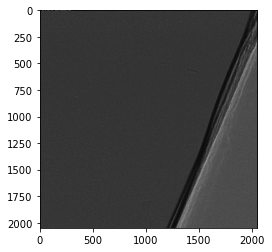

In [232]:
plt.imshow(ff_corrected[5], cmap = 'gray')

You need to start using ROI for better FF-corection

## Stitch

In [233]:
def Reverse(lst):
    return [ele for ele in reversed(lst)]


def stitchme_from_array(images, crop = np.s_[:,
                                             :int(motor_step_pix) - 90,
                                             :int(motor_step_pix) - 90]):
    
    # this part is questionable, the offset should be calculated better above
    images = images[crop]
    
    outs = []
    for ver in range(7):
        i=ver*17
        current_line = np.concatenate([k for k in reversed(images[i:i+17])], axis = 1)
        outs.append(current_line)
    
    # pack everything in one array and return one image
    outs = np.asarray(Reverse(outs))
    
    return (outs.reshape(outs.shape[0]*outs.shape[1], outs.shape[2]))

In [250]:
motor_step_mm = 0.25*1e-3
pixel_size = 6.5/40 *1e-6
motor_step_pix = motor_step_mm/pixel_size 

image_size = 2048
crop_area = 2048 - int(motor_step_pix)


#test = stitchme_from_array(ff_corrected)
#test = stitchme_from_array(ff_corrected, np.s_[:, int(crop_area/2):-int(crop_area/2) - 90, int(crop_area/2):-int(crop_area/2) - 90])

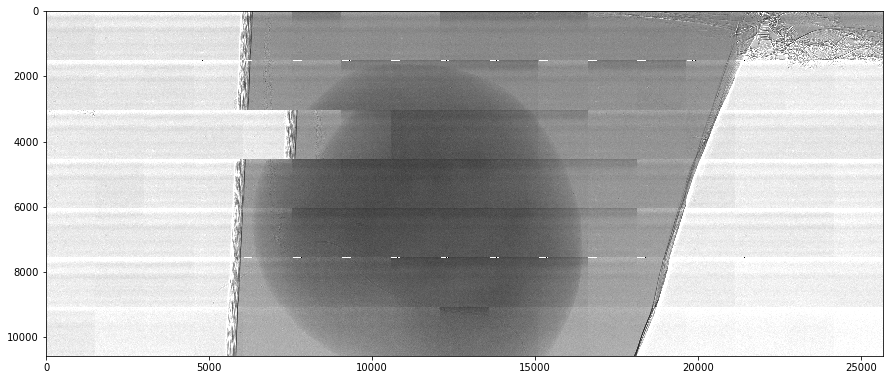

In [239]:
plt.figure(figsize = (15,15))
plt.imshow(test, cmap = 'gray', vmax = 1)

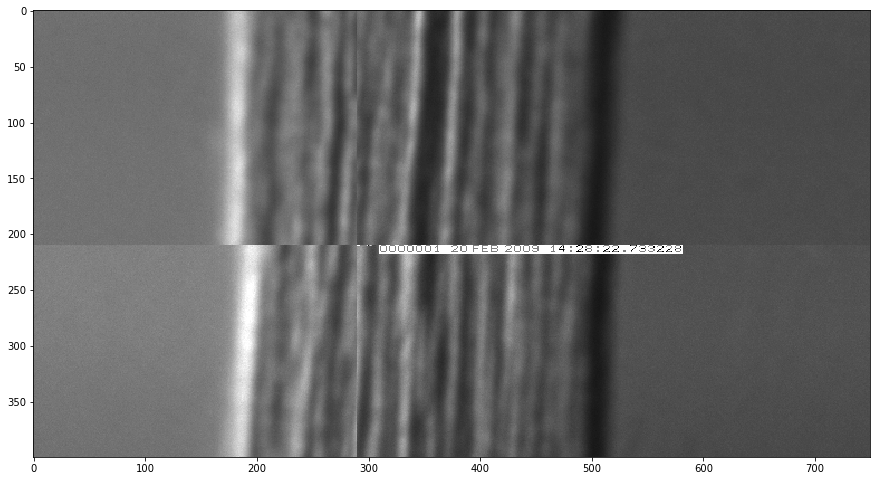

In [255]:
plt.figure(figsize = (15,15))
plt.imshow(test[1300:1700, 5750:6500], cmap = 'gray', vmax = 2)

In [245]:
30*1e-6 * 140*1e-3

4.2e-06

In [244]:
# расходимость
30*1e-6 * 140*1e-3 / pixel_size

26.88

# BITS AND PIECES

## ff-correction - beta version

**test data**

In [9]:
# select just one distance and one acquisition
def find_paths_single_distance(data_list, key):
    return [i for i in data_list if i.startswith(key)]
    #return [i for i in data_list if i.startswith('ff_try0_full_'+distance+'mm_'+section+'_')


In [94]:
# take some random set
data_test = find_paths_single_distance(imlist, 'try0_full_140mm_1')
ff_test = find_paths_single_distance(imlist, 'ff_try0_full_140mm_1')
data_test.sort(), ff_test.sort()


# note -> sort function could be improved 

(None, None)

In [95]:
#set the ROI of image first, the logic corresponds to FIJI (to be read (x,y,x1,y1 at the image - inverse to numpy!)
ROI = (100,100,2048,2048) 
folder = '/mnt/beegfs/P14/2020/p3l-gleb1/20201129/RAW_DATA/imaging/'
#folder = '/Users/au704469/Documents/Postdoc/Results/X-ray_tomography/Brain_organoid_P14_DESY_Nov2020/Data_test/'+distance+'mm/'


In [96]:
# test with just 3 images
image_data = data_test[:3]
ff_data = ff_test

In [97]:
images = np.asarray([tifffile.imread(folder+im) for im in image_data])
images = images[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

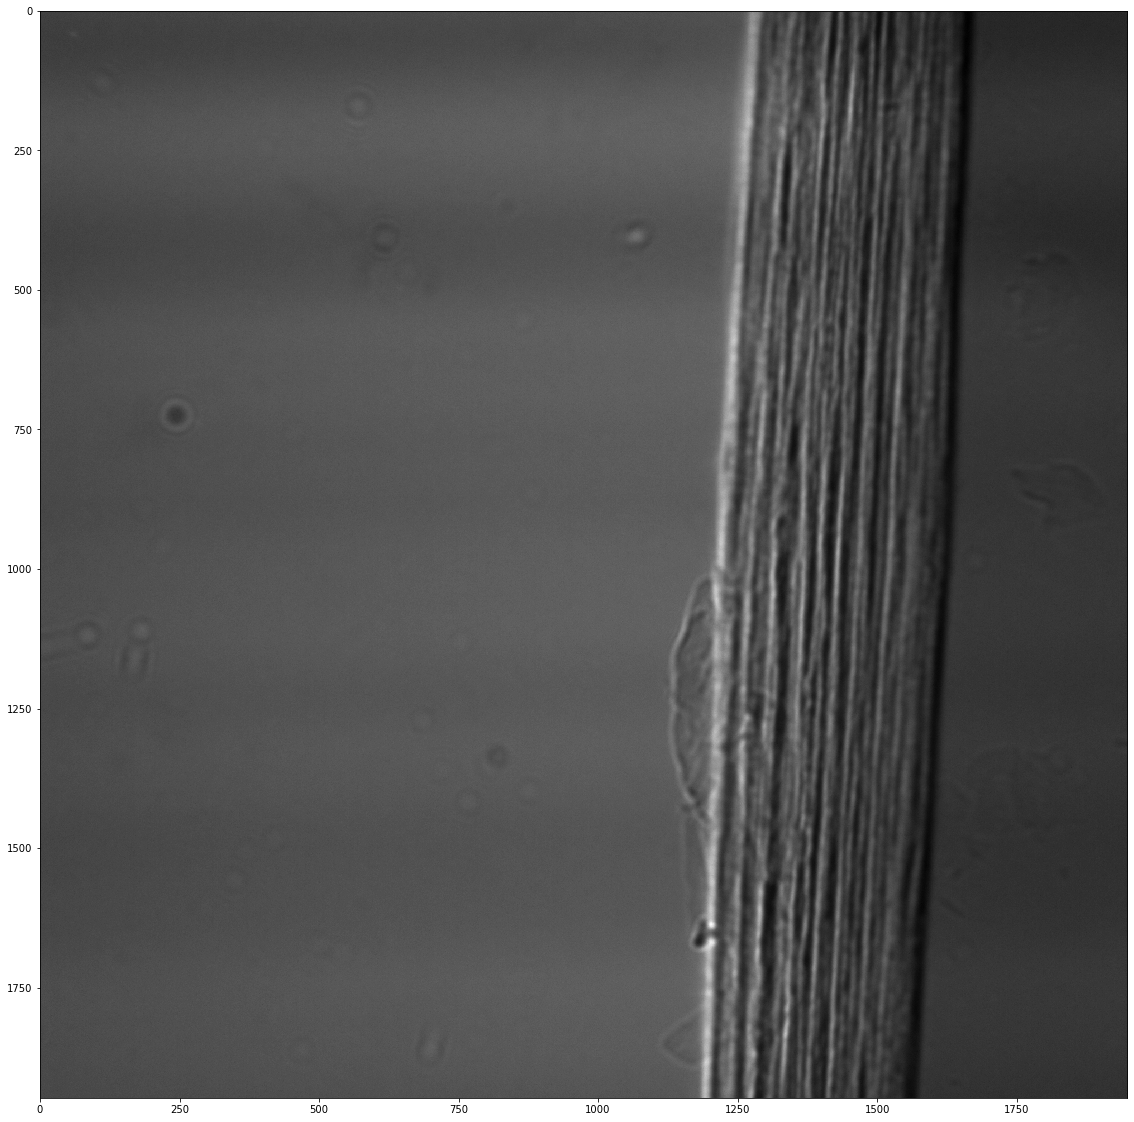

In [98]:
# not filtered image
var.show(images[2])

In [99]:
flatfield = np.asarray([tifffile.imread(folder+im) for im in ff_data])
flatfield = flatfield[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]
flatfield = np.transpose(flatfield, (1,2,0))

In [100]:
# images should be set as special classes:
ff_class = SSIM.SSIM_const(flatfield)

# a list to store results
result = []

for count,item in enumerate(images):
    image_class = SSIM.SSIM_const(item)
    index = SSIM.SSIM(image_class, ff_class).ssim()
    result.append(np.asarray(item/flatfield[:,:,np.argmax(index)]))
    print('processed image ', image_data[count])

processed image  try0_full_140mm_100_00001.tiff
processed image  try0_full_140mm_100_00002.tiff
processed image  try0_full_140mm_100_00003.tiff


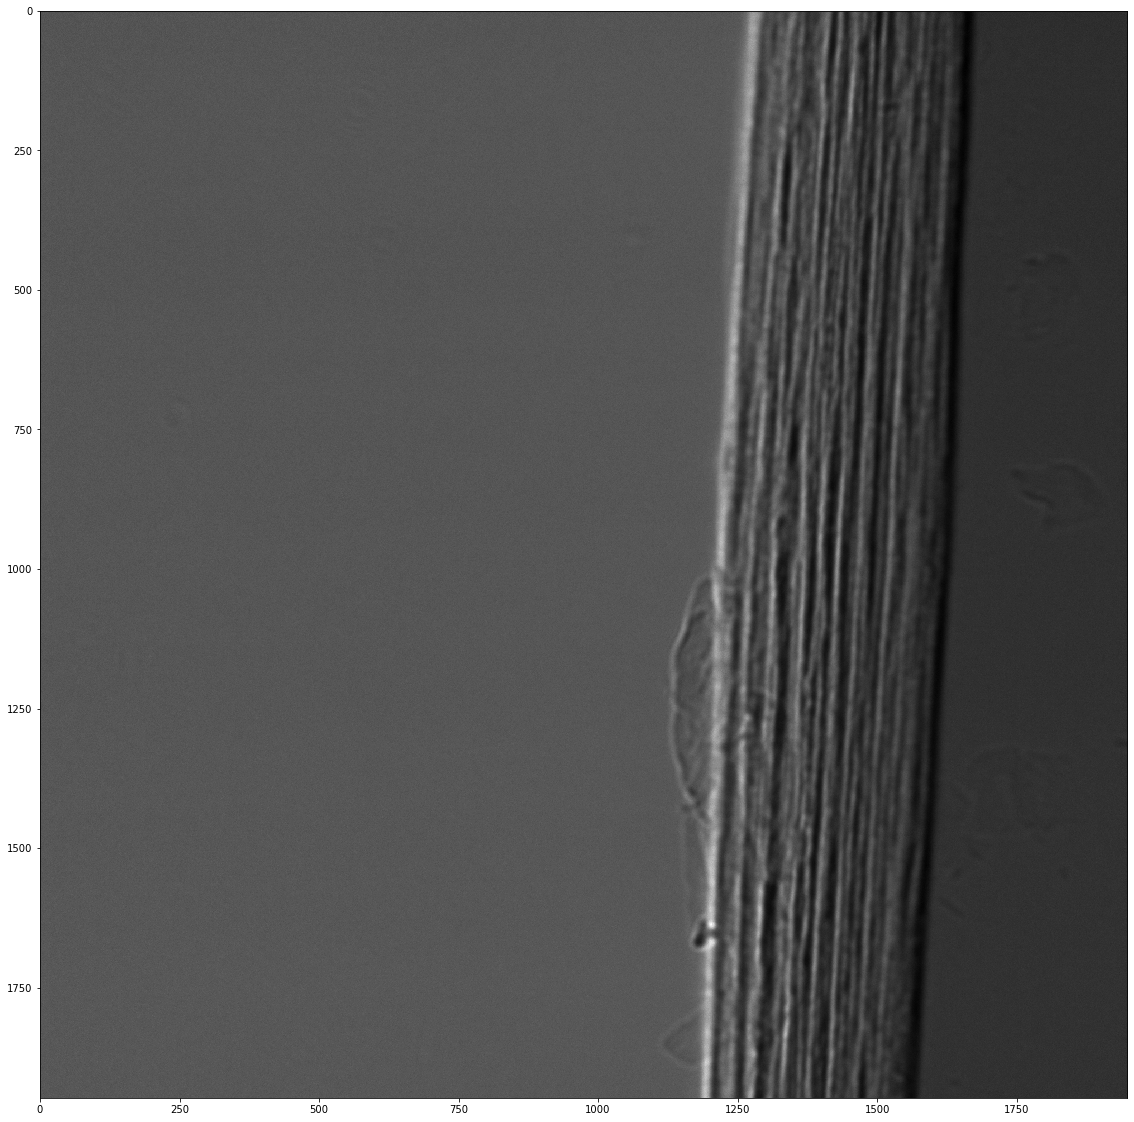

In [101]:
# filtered image
var.show(result[2])

**try a function for ff-correction**

In [105]:
def ff_correct_one(image_data, ff_data, ROI=(0,0,2048,2048)):    
    """
    This function takes 1 data image and ff corrects it
    
    image_data: str
        path to images
    ff_data: list
        paths to ff
        
    Returns
    out: 3D numpy array
    """
    

    # read images
    images = np.asarray([tifffile.imread(folder+im) for im in image_data])
    images = images[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

    #read ff-files
    flatfield = np.asarray([tifffile.imread(folder+im) for im in ff_data])
    flatfield = flatfield[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

    # please transpose the ff-array for the further ff-correction
    flatfield = np.transpose(flatfield, (1,2,0))
    
    # images should be set as special classes:
    image_class = SSIM.SSIM_const(images)
    ff_class = SSIM.SSIM_const(flatfield)

    # then, you can calculate SSIM metrics for each pair (data-image) - (ff-image)
    index = SSIM.SSIM(image_class, ff_class).ssim()

    # now, simply divide your image by flatfield-image with highest SSIM-index and get a corrected image:
    result = np.asarray(images[:]/flatfield[:,:,np.argmax(index)])
    return result






def ff_correct_list(image_data, ff_data, ROI=(0,0,2048,2048)):    
    """
    This function takes several data images and ff corrects it
    
    image_data: list
        paths to images
    ff_data: list
        paths to ff
        
    Returns
    out: 3D numpy array
    """
    

    # read images
    images = np.asarray([tifffile.imread(folder+im) for im in image_data])
    images = images[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

    #read ff-files
    flatfield = np.asarray([tifffile.imread(folder+im) for im in ff_data])
    flatfield = flatfield[:,ROI[1]:ROI[3], ROI[0]:ROI[2]]

    # please transpose the ff-array for the further ff-correction
    flatfield = np.transpose(flatfield, (1,2,0))
    
    # images should be set as special classes:
    ff_class = SSIM.SSIM_const(flatfield)

    # a list to store results
    result = []

    for count,item in enumerate(images):
        image_class = SSIM.SSIM_const(item)
        index = SSIM.SSIM(image_class, ff_class).ssim()
        result.append(np.asarray(item/flatfield[:,:,np.argmax(index)]))
        print('processed image ', image_data[count])
        
    return result


In [106]:
test = ff_correct_list(data_test[:3],ff_test, ROI=ROI)

processed image  try0_full_140mm_100_00001.tiff
processed image  try0_full_140mm_100_00002.tiff
processed image  try0_full_140mm_100_00003.tiff


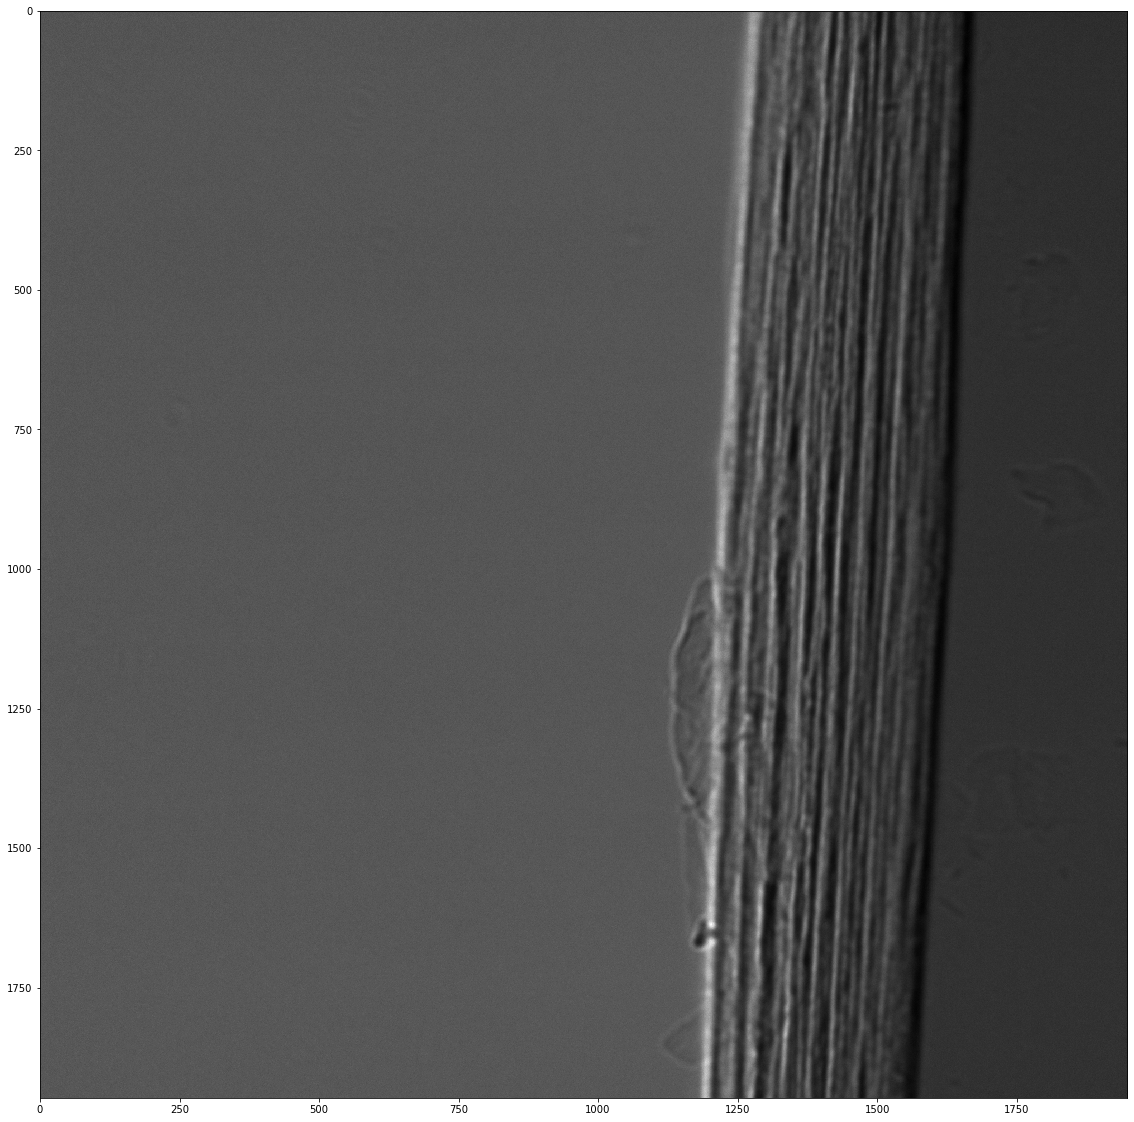

In [107]:
# filtered image
var.show(test[2])

## stitching - test approach

In [8]:
data_test = find_paths_single_distance_all(imlist, key ='try0', distance = '140mm', image = '0001.tiff')

# note - this sorting may not work for other examples (other than 140mm distance), needs to be tested
data_test = sorted(data_test, key=lambda i: int(find_counter(i)))

In [133]:
def Reverse(lst):
    return [ele for ele in reversed(lst)]

In [130]:
motor_step_mm = 0.25*1e-3
pixel_size = 6.25/40 *1e-6
motor_step_pix = motor_step_mm/pixel_size 

image_size = 2048
crop_area = 2048 - int(motor_step_pix)



list_of_images = data_test

full_paths = [folder + i for i in list_of_images]
images = tifffile.imread(full_paths)

# this part is questionable, the offset doesn't fit calculations (90 pix error)
images = images[:,:int(motor_step_pix)-90,:int(motor_step_pix)-90]

outs = []
for ver in range(7):
    i=ver*17
    current_line = np.concatenate([k for k in reversed(images[i:i+17])], axis = 1)
    outs.append(current_line)
    
outs = np.asarray(Reverse(outs))
newarr = outs.reshape(outs.shape[0]*outs.shape[1], outs.shape[2])

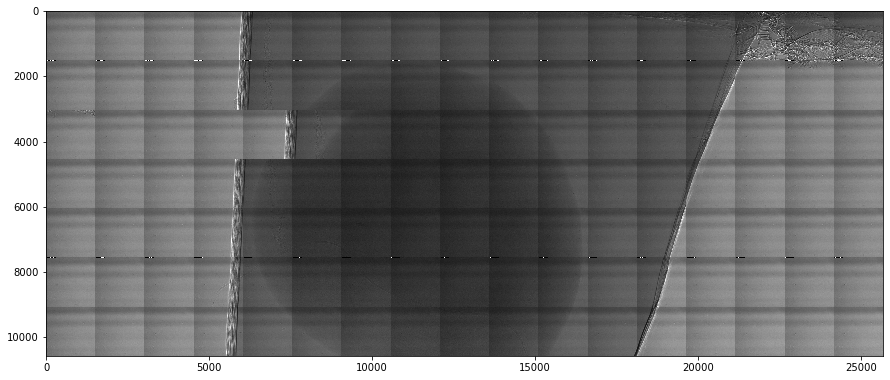

In [132]:
plt.figure(figsize = (15,15))
plt.imshow(newarr, cmap = 'gray', vmax = 20000)

**stichting - function**

In [140]:
def Reverse(lst):
    return [ele for ele in reversed(lst)]


def stitchme_from_list(list_of_images, folder = folder, crop = np.s_[:,:int(motor_step_pix)-90,:int(motor_step_pix)-90]):
    
    full_paths = [folder + i for i in list_of_images]
    images = tifffile.imread(full_paths)
    
    # this part is questionable, the offset should be calculated better above
    images = images[crop]
    
    outs = []
    for ver in range(7):
        i=ver*17
        current_line = np.concatenate([k for k in reversed(images[i:i+17])], axis = 1)
        outs.append(current_line)
    
    # pack everything in one array and return one image
    outs = np.asarray(Reverse(outs))
    
    return (outs.reshape(outs.shape[0]*outs.shape[1], outs.shape[2]))
  

In [141]:
motor_step_mm = 0.25*1e-3
pixel_size = 6.25/40 *1e-6
motor_step_pix = motor_step_mm/pixel_size 

image_size = 2048
crop_area = 2048 - int(motor_step_pix)


test = stitchme_from_list(data_test)

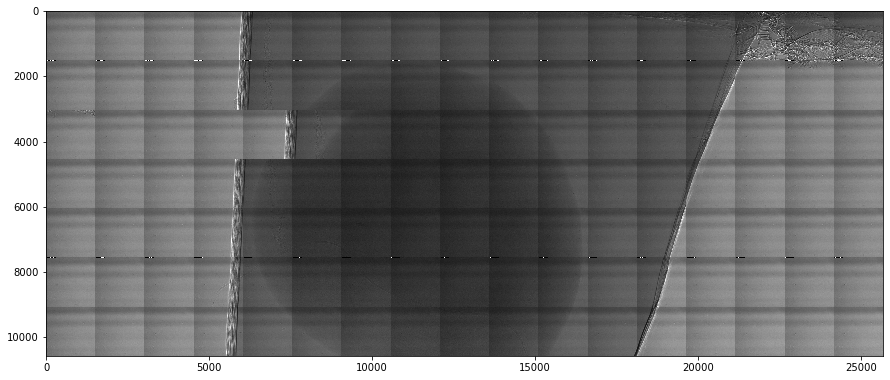

In [142]:
plt.figure(figsize = (15,15))
plt.imshow(test, cmap = 'gray', vmax = 20000)